# Tomato Leaf Classification

# Imports

In [84]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, MaxPool2D, Flatten, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Constants

In [4]:
PATH = "/Users/maukanmir/Downloads/archive/"
BATCH_SIZE=64
INPUT_SHAPE = (224,224,3)

train_path, val_path, test_path = PATH +"train/", PATH +"valid/", PATH +"test/"

# Functions

In [75]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_process(img_path, target_size=INPUT_SHAPE):
  try:
    with Image.open(img_path) as img:
      img = img.resize(target_size[:2])
      img = img.convert("RGB")
      
      img_arr = np.array(img)/255.0
      img_arr = img_arr.astype(np.float32)
      return img_arr
  except IOError as e:
    print(f"This Image was not able to be processed: {e}")
    return None

def grab_images(path, size=None):
  
  images, labels = [], []
  
  for root, dirs, files in os.walk(path):
    for file in files:
      if size and len(labels) == size:
        return np.array(images), np.array(labels)
      if file.lower().endswith((".png", ".jpg", ".jpeg")):
        img_path = os.path.join(root, file)
        img = load_process(img_path)
        if img is not None:
          images.append(img)
          label = root.split(os.sep)[-1]
          labels.append(label)
  
  images, labels = np.array(images), np.array(labels)
  return images, labels

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 8))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10,12))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def create_model(n_classes, input_shape=INPUT_SHAPE):
  
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=INPUT_SHAPE),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Conv2D(356, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(n_classes, activation="softmax")
  ])
  
  model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  
  model.summary()
  
  return model

def plot_images(images, labels, num_images=12, img_size=INPUT_SHAPE):
  
  indices = np.arange(len(images))
  np.random.shuffle(indices)
  plt.figure(figsize=(10,10))
  
  for i in range(num_images):
    plt.subplot(3,4, i+1)
    idx = indices[i]
    img = images[idx].reshape(img_size)
    plt.imshow(img)
    plt.title(labels[idx])
    plt.axis("off")
  plt.show()
  
def plot_learning_curves(history):
  acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
  loss, val_loss = history.history["loss"], history.history["val_loss"]
  
  epochs = range(1, len(acc)+1)
  
  plt.figure(figsize=(10,8))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc,"bo-",label="Training Accuracy")
  plt.plot(epochs, val_acc,"gs-", label="Validation Accuracy")
  plt.title("Training & Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  
  plt.subplot(1,2,2)
  plt.plot(epochs, loss,"bo-" ,label="Training Loss")
  plt.plot(epochs, val_loss, "gs-", label="Validation Loss")
  plt.title("Training & Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  
  plt.tight_layout()
  plt.show()
  

# Load Images

In [61]:
X_train, y_train = grab_images(train_path, 2000)
X_val, y_val = grab_images(val_path, 1000)
X_test, y_test = grab_images(test_path, 1000)

In [59]:
print(f"Training shape: {X_train.shape[0]}, {y_train.shape[0]}")
print(f"Validation shape: {X_val.shape[0]}, {y_val.shape[0]}")
print(f"Test shape: {X_test.shape[0]}, {y_test.shape[0]}")

Training shape: 2500, 2500
Validation shape: 2625, 2625
Test shape: 2625, 2625


# EDA Analysis

# Check Class Imabalance

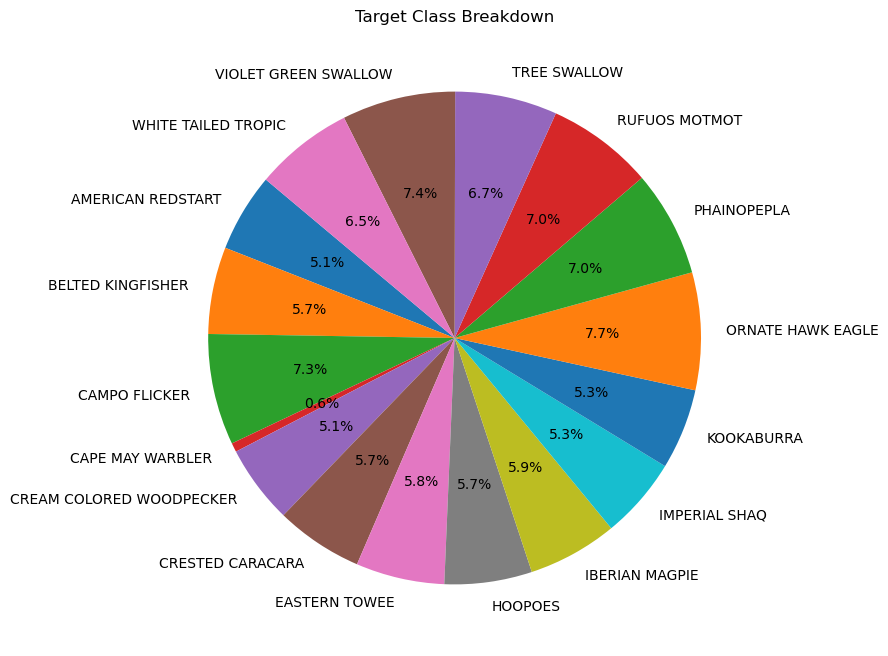

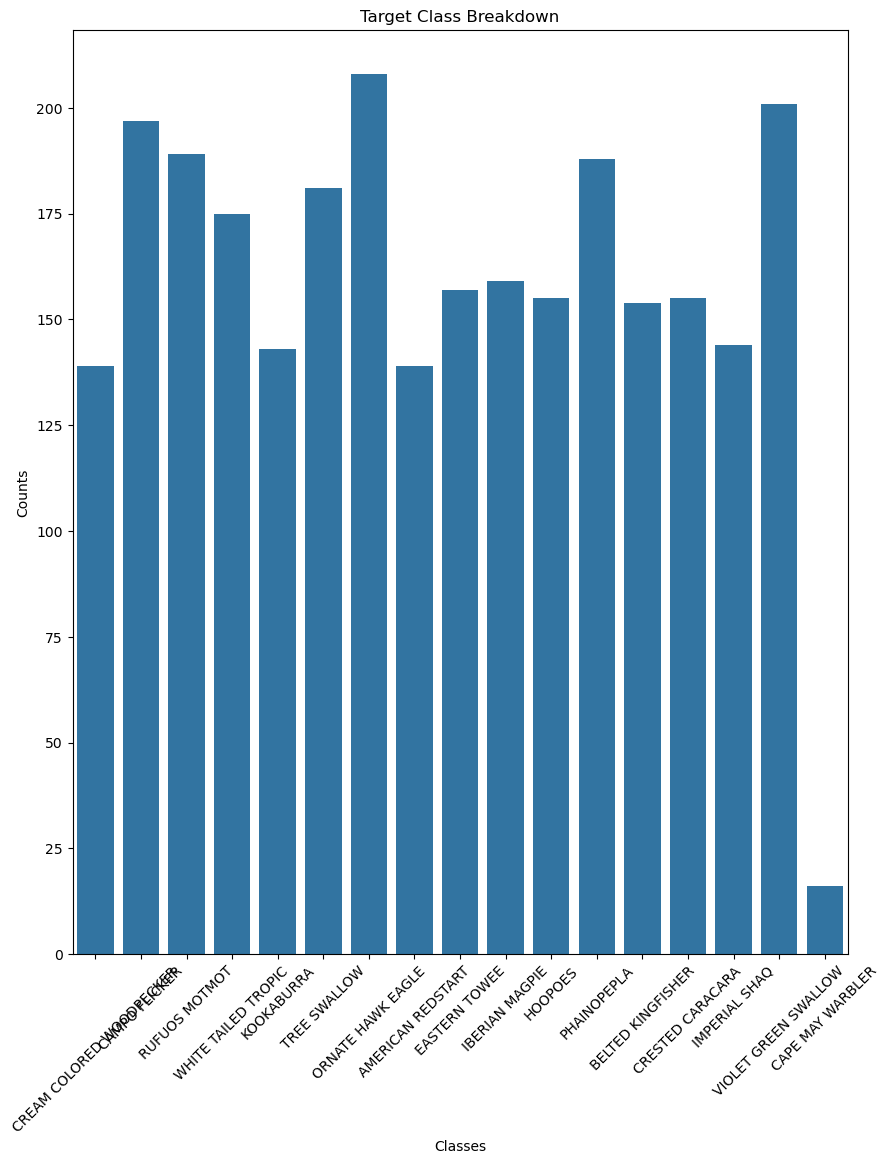

In [55]:
check_class_imbalance(y_train)

# Stratify Data

In [85]:
X = np.concatenate([X_train, X_val, X_test], axis=0)
y = np.concatenate([y_train, y_val, y_test], axis=0)

In [86]:
X_temp, X_test, y_temp, y_test = train_test_split(X,y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)

In [87]:
print(f"Training shape: {X_train.shape[0]}, {y_train.shape[0]}")
print(f"Validation shape: {X_val.shape[0]}, {y_val.shape[0]}")
print(f"Test shape: {X_test.shape[0]}, {y_test.shape[0]}")

Training shape: 2400, 2400
Validation shape: 800, 800
Test shape: 800, 800


# Target class has some rare birds

# First look at our images

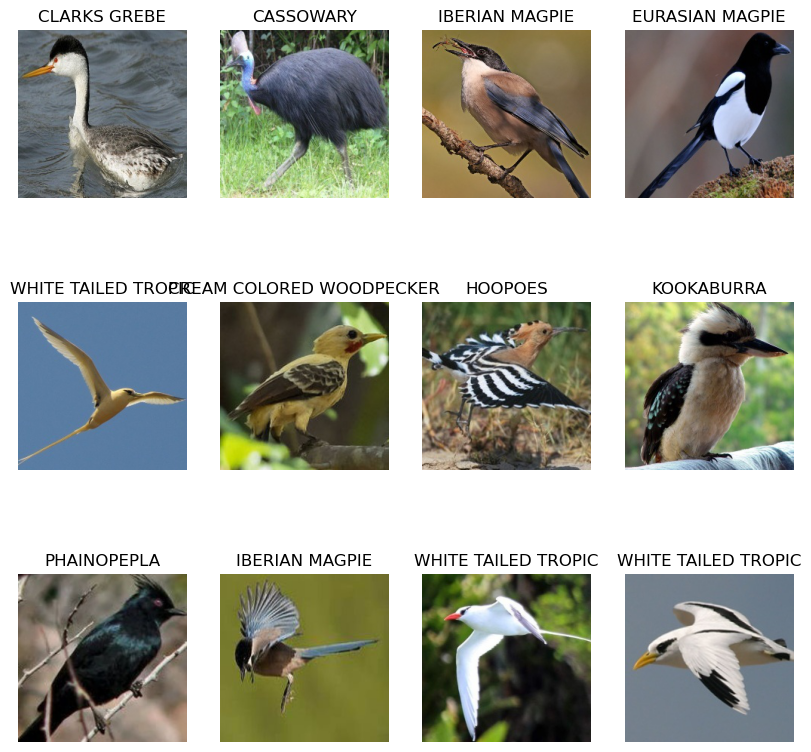

In [88]:
plot_images(X_train,y_train)

# Label encode and One hot encode target variables

In [89]:
class ExtendedLabelEncoder(LabelEncoder):
    def __init__(self, handle_unknown='ignore'):
        self.handle_unknown = handle_unknown
        self.unknown_value = -1 
        super().__init__()
    
    def transform(self, y):
        try:
            return super().transform(y)
        except ValueError as e:
            if self.handle_unknown == 'ignore':
                return np.array([self.unknown_value if label not in self.classes_ else self.transform([label])[0] for label in y])
            else:
                raise e

encoder = ExtendedLabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)


y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

NUM_CLASSES = len(encoder.classes_)
one_hot_encoded_y_train = to_categorical(y_train_encoded, num_classes=NUM_CLASSES)
one_hot_encoded_y_val = to_categorical(y_val_encoded, num_classes=NUM_CLASSES)
one_hot_encoded_y_test = to_categorical(y_test_encoded, num_classes=NUM_CLASSES)

# We should incorporate data augmentation to ensure our model generalizes to unseen images

# Data Augmentation

In [90]:
train_datagen = ImageDataGenerator(
rotation_range=40,
horizontal_flip=True,
shear_range=0.2,
fill_mode="nearest"
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
  X_train,
  one_hot_encoded_y_train,
  batch_size=BATCH_SIZE
)

val_generator = val_datagen.flow(
  X_val,
  one_hot_encoded_y_val,
  batch_size=BATCH_SIZE
)

test_generator = test_datagen.flow(
  X_test,
  one_hot_encoded_y_test,
  batch_size=BATCH_SIZE
)

# Create Model

In [91]:
model = create_model(NUM_CLASSES)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_380 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_381 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_382 (Conv2D)         (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 26, 26, 128)     

# Early Stopping and Call Backs

In [92]:
early_stopping = EarlyStopping(
  monitor="val_loss",
  min_delta=0.01,
  patience=15,
  verbose=0,
  mode="min",
  restore_best_weights=True
)

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_val.shape[0]//BATCH_SIZE
test_steps = X_test.shape[0]//BATCH_SIZE

# Fitting the model

In [93]:
history = model.fit(
  train_generator,
  steps_per_epoch=steps_per_epoch,
  epochs=100,
  validation_data=val_generator,
  validation_steps=validation_steps,
  callbacks=[early_stopping]
)

Epoch 1/100
37/37 [==============================] - 23s 596ms/step - loss: 4.9635 - accuracy: 0.0394 - val_loss: 4.5783 - val_accuracy: 0.0794
Epoch 2/100
37/37 [==============================] - 23s 618ms/step - loss: 4.5723 - accuracy: 0.0830 - val_loss: 4.3203 - val_accuracy: 0.1497
Epoch 3/100
37/37 [==============================] - 23s 622ms/step - loss: 4.3278 - accuracy: 0.1190 - val_loss: 4.0893 - val_accuracy: 0.2031
Epoch 4/100
37/37 [==============================] - 23s 620ms/step - loss: 4.1322 - accuracy: 0.1627 - val_loss: 3.8288 - val_accuracy: 0.2656
Epoch 5/100
37/37 [==============================] - 23s 619ms/step - loss: 3.9723 - accuracy: 0.1999 - val_loss: 3.8198 - val_accuracy: 0.2747
Epoch 6/100
37/37 [==============================] - 23s 629ms/step - loss: 3.8140 - accuracy: 0.2200 - val_loss: 3.6236 - val_accuracy: 0.2799
Epoch 7/100
37/37 [==============================] - 23s 629ms/step - loss: 3.6368 - accuracy: 0.2547 - val_loss: 3.4844 - val_accuracy:

In [94]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print("Test Accuracy", test_acc)

12/12 [==============================] - 2s 154ms/step - loss: 2.4164 - accuracy: 0.5104
Test Accuracy 0.5104166865348816


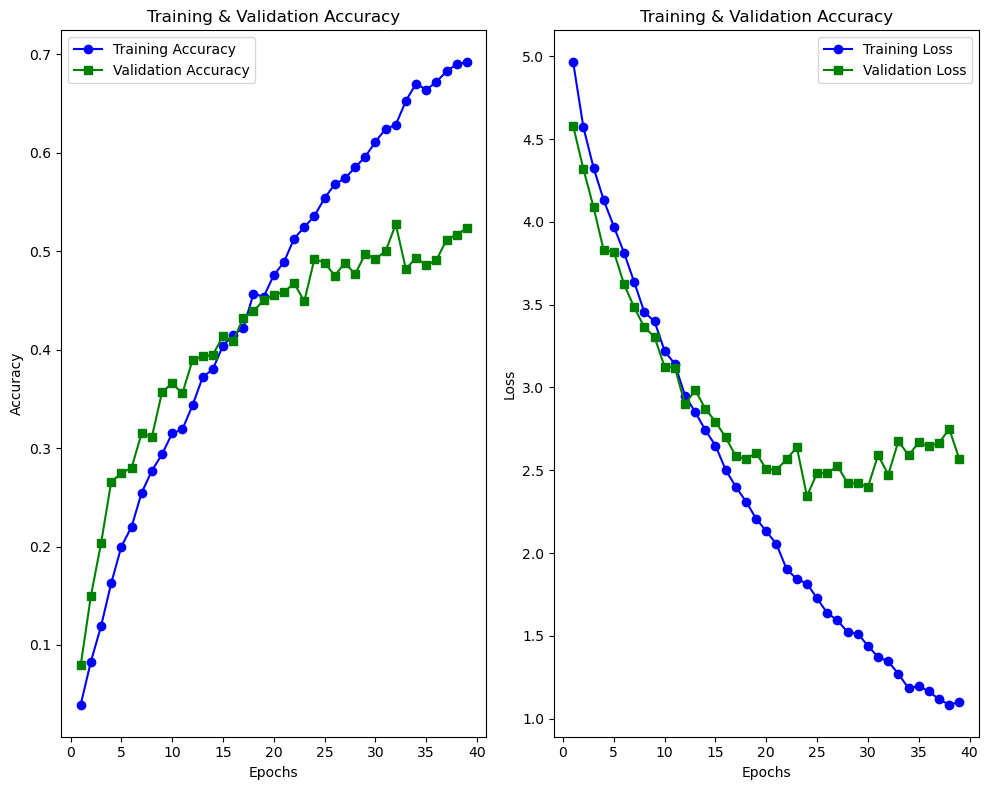

In [95]:
plot_learning_curves(history)

# Lets test the Inception Model

In [96]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

for layer in base_model.layers:
  layer.trainable = False

X = base_model.output
X = GlobalAveragePooling2D()(X)
X = Dense(128, activation="relu")(X)
X = Dropout(0.2)(X)
prediction = Dense(NUM_CLASSES, activation="softmax")(X)

model_v3 = Model(inputs=base_model.input, outputs=prediction)

model_v3.compile(
  loss="categorical_crossentropy",
  optimizer="adam",
  metrics=["accuracy"]
)

history = model.fit(
  train_generator,
  steps_per_epoch=steps_per_epoch,
  epochs=100,
  validation_data=val_generator,
  validation_steps= validation_steps,
  callbacks=[early_stopping]
)

Epoch 1/100
37/37 [==============================] - 23s 629ms/step - loss: 1.7030 - accuracy: 0.5574 - val_loss: 2.3818 - val_accuracy: 0.4805
Epoch 2/100
37/37 [==============================] - 23s 615ms/step - loss: 1.6028 - accuracy: 0.5702 - val_loss: 2.5711 - val_accuracy: 0.4661
Epoch 3/100
37/37 [==============================] - 23s 609ms/step - loss: 1.5306 - accuracy: 0.5890 - val_loss: 2.4077 - val_accuracy: 0.4857
Epoch 4/100
37/37 [==============================] - 23s 609ms/step - loss: 1.4741 - accuracy: 0.6074 - val_loss: 2.3415 - val_accuracy: 0.5104
Epoch 5/100
37/37 [==============================] - 23s 609ms/step - loss: 1.5638 - accuracy: 0.5830 - val_loss: 2.4718 - val_accuracy: 0.5000
Epoch 6/100
37/37 [==============================] - 23s 615ms/step - loss: 1.3790 - accuracy: 0.6220 - val_loss: 2.6377 - val_accuracy: 0.4948
Epoch 7/100
37/37 [==============================] - 23s 624ms/step - loss: 1.3527 - accuracy: 0.6199 - val_loss: 2.4571 - val_accuracy:

In [97]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print("Test Accuracy", test_acc)

12/12 [==============================] - 2s 149ms/step - loss: 2.4066 - accuracy: 0.5052
Test Accuracy 0.5052083134651184


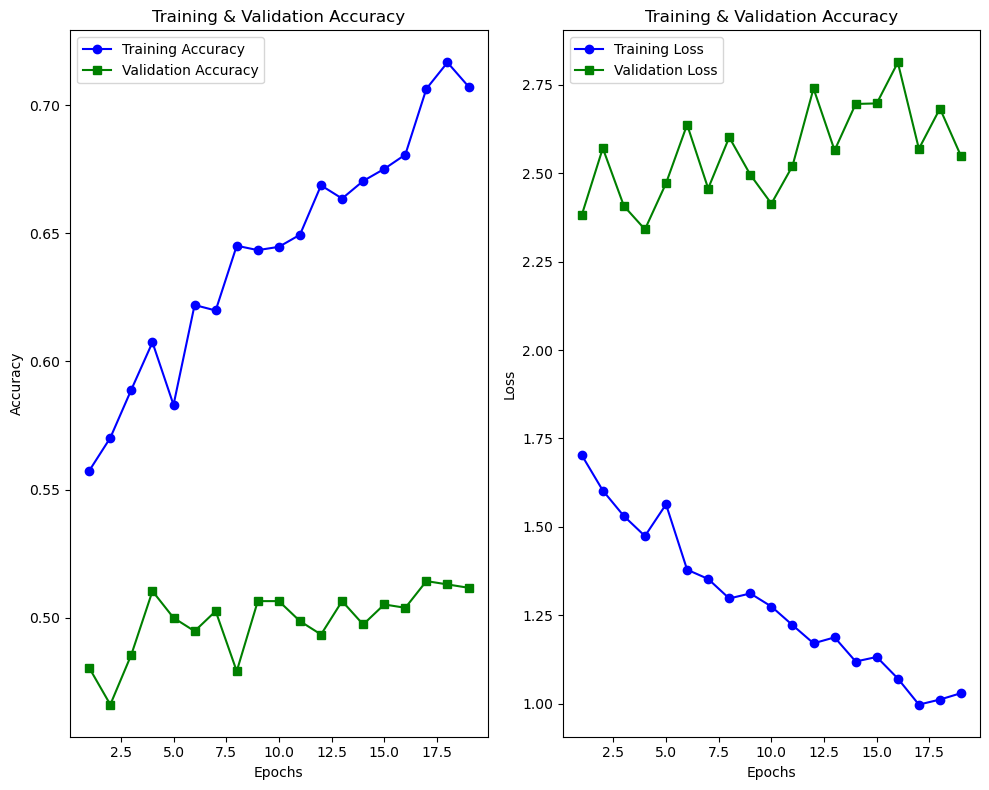

In [98]:
plot_learning_curves(history)

# Model is performing poorly on the validation and test data which suggests it cannot generalize.